## Datasyn og dyp læring - TDT 4265

### Assignment 3 - Convolutional networks

- In this assignment, we will perform image classification of images in the CIFAR10 dataset. This assignment will focus on pytorch

#### Task 1 - Convolutional Neural Networks 
- Implementing a CNN as described in with this figure
- Classifying the CIFAR-10 dataset(60, 000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10, 000 test images)
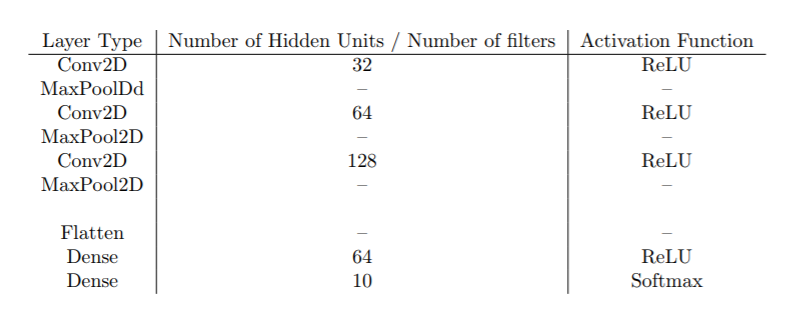
- Using filter size of 5x5 with a padding of 2 for each convolution
- max pool operation useing a kernel size of 2x2 with a stride of 2

In [2]:
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from dataloaders import load_cifar10
from utils import to_cuda, compute_loss_and_accuracy

In [19]:
#TIPS

#To check the GPU utilization you can simply write in bash:
#nvidia-smi
#To check the CPU utilization and current RAM usage, write in bash:
#top

In [53]:
#from starter_code

class Task1Model(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        num_filters = 32  # Set number of filters in first conv layer

        # Define the convolutional layers
        self.feature_extractor = nn.Sequential(
            #layer 1
            nn.Conv2d(
                in_channels=image_channels,
                out_channels=num_filters,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #layer 2
            nn.Conv2d(
                in_channels=num_filters,
                out_channels=num_filters*2,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #layer 3
            nn.Conv2d(
                in_channels=num_filters*2,
                out_channels=num_filters*4,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # The output of feature_extractor will be [batch_size, num_filters*4, 4, 4]
        self.num_output_features = num_filters*4*4*4
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
        self.classifier = nn.Sequential(
            nn.Linear(self.num_output_features, num_classes),
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """

        # Run image through convolutional layers
        x = self.feature_extractor(x)
        # Reshape our input to (batch_size, num_output_features)
        x = x.view(-1, self.num_output_features)
        # Forward pass through the fully-connected layers.
        x = self.classifier(x)
        return x


In [54]:
class Trainer:

    def __init__(self):
        """
        Initialize our trainer class.
        Set hyperparameters, architecture, tracking variables etc.
        """
        # Define hyperparameters
        self.epochs = 10
        self.batch_size = 64
        self.learning_rate = 5e-2
        self.early_stop_count = 4

        # Architecture

        # Since we are doing multi-class classification, we use the CrossEntropyLoss
        self.loss_criterion = nn.CrossEntropyLoss()
        # Initialize the mode
        self.model = Task1Model(image_channels=3, num_classes=10)
        
        # Transfer model to GPU VRAM, if possible.
        self.model = to_cuda(self.model)

        # Define our optimizer. SGD = Stochastich Gradient Descent
        self.optimizer = torch.optim.SGD(self.model.parameters(),
                                         self.learning_rate)

        # Load our dataset
        self.dataloader_train, self.dataloader_val, self.dataloader_test = load_cifar10(self.batch_size)

        self.validation_check = len(self.dataloader_train) // 2

        # Tracking variables
        self.VALIDATION_LOSS = []
        self.TEST_LOSS = []
        self.TRAIN_LOSS = []
        self.TRAIN_ACC = []
        self.VALIDATION_ACC = []
        self.TEST_ACC = []

    def validation_epoch(self):
        """
            Computes the loss/accuracy for all three datasets.
            Train, validation and test.
        """
        self.model.eval()

        # Compute for training set
        train_loss, train_acc = compute_loss_and_accuracy(
            self.dataloader_train, self.model, self.loss_criterion
        )
        self.TRAIN_ACC.append(train_acc)
        self.TRAIN_LOSS.append(train_loss)

        # Compute for validation set
        validation_loss, validation_acc = compute_loss_and_accuracy(
            self.dataloader_val, self.model, self.loss_criterion
        )
        self.VALIDATION_ACC.append(validation_acc)
        self.VALIDATION_LOSS.append(validation_loss)
        print("Current validation loss:", validation_loss, " Accuracy:", validation_acc)
        # Compute for testing set
        test_loss, test_acc = compute_loss_and_accuracy(
            self.dataloader_test, self.model, self.loss_criterion
        )
        self.TEST_ACC.append(test_acc)
        self.TEST_LOSS.append(test_loss)

        self.model.train()

    def should_early_stop(self):
        """
        Checks if validation loss doesn't improve over early_stop_count epochs.
        """
        # Check if we have more than early_stop_count elements in our validation_loss list.
        if len(self.VALIDATION_LOSS) < self.early_stop_count:
            return False
        # We only care about the last [early_stop_count] losses.
        relevant_loss = self.VALIDATION_LOSS[-self.early_stop_count:]
        previous_loss = relevant_loss[0]
        for current_loss in relevant_loss[1:]:
            # If the next loss decrease, early stopping criteria is not met.
            if current_loss < previous_loss:
                return False
            previous_loss = current_loss
        return True

    def train(self):
        """
        Trains the model for [self.epochs] epochs.
        """
        # Track initial loss/accuracy
        self.validation_epoch()
        for epoch in range(self.epochs):
            # Perform a full pass through all the training samples
            for batch_it, (X_batch, Y_batch) in enumerate(self.dataloader_train):
                # X_batch is the CIFAR10 images. Shape: [batch_size, 3, 32, 32]
                # Y_batch is the CIFAR10 image label. Shape: [batch_size]
                # Transfer images / labels to GPU VRAM, if possible
                X_batch = to_cuda(X_batch)
                Y_batch = to_cuda(Y_batch)

                # Perform the forward pass
                predictions = self.model(X_batch)
                # Compute the cross entropy loss for the batch
                loss = self.loss_criterion(predictions, Y_batch)

                # Backpropagation
                loss.backward()

                # Gradient descent step
                self.optimizer.step()
                
                # Reset all computed gradients to 0
                self.optimizer.zero_grad()
                 # Compute loss/accuracy for all three datasets.
                if batch_it % self.validation_check == 0:
                    self.validation_epoch()
                    # Check early stopping criteria.
                    if self.should_early_stop():
                        print("Early stopping.")
                        return


In [55]:
if __name__ == "__main__":
    trainer = Trainer()
    trainer.train()

    os.makedirs("plots", exist_ok=True)
    # Save plots and show them
    plt.figure(figsize=(12, 8))
    plt.title("Cross Entropy Loss")
    plt.plot(trainer.VALIDATION_LOSS, label="Validation loss")
    plt.plot(trainer.TRAIN_LOSS, label="Training loss")
    plt.plot(trainer.TEST_LOSS, label="Testing Loss")
    plt.legend()
    plt.savefig(os.path.join("plots", "final_loss.png"))
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.title("Accuracy")
    plt.plot(trainer.VALIDATION_ACC, label="Validation Accuracy")
    plt.plot(trainer.TRAIN_ACC, label="Training Accuracy")
    plt.plot(trainer.TEST_ACC, label="Testing Accuracy")
    plt.legend()
    plt.savefig(os.path.join("plots", "final_accuracy.png"))
    plt.show()

    print("Final test accuracy:", trainer.TEST_ACC[-trainer.early_stop_count])
    print("Final validation accuracy:", trainer.VALIDATION_ACC[-trainer.early_stop_count])

Files already downloaded and verified
Files already downloaded and verified
Current validation loss: 2.2987029552459717  Accuracy: 0.113
Current validation loss: 2.297587968126128  Accuracy: 0.1158
Current validation loss: 1.498206610921063  Accuracy: 0.4648
Current validation loss: 1.5841461736944658  Accuracy: 0.447


KeyboardInterrupt: 